In [1]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import numpy as np
import tensorflow as tf
import keras
from keras import layers

from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix

import rasterio
from rasterio import plot as rastPlt
from rasterio.plot import reshape_as_raster

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
#pathSatellite = folderName + "Landsat-8.tif"
#pathNight = folderName + "Night VIIRS_1.tif"
pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, validThreshold=0, area=aoi)

print('Tiles:',dataCoords.shape[0])


Tiles: 139113


In [3]:
# Fetch images
lightMask = dataRadiance>1
idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[dataRadiance<=1],500, replace=False)
darkData = dataCoords[idxDarkData]
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.getEachImgFromCoord(f, np.concatenate((dataCoords[lightMask], darkData)), True)
trainData = utils.formatData(trainData, res=64, toFloat=True)
print('Light Tile:',len(trainData)-len(darkData))
print('dark Tile:',len(darkData))
print('Total train',trainData.shape)

train = trainData
validation = np.concatenate((dataRadiance[lightMask], dataRadiance[idxDarkData])).astype("float32") / 255

Light Tile: 1472
dark Tile: 500
Total train (1972, 64, 64, 3)


## CNN

In [4]:
autoencoder = keras.models.load_model('model/autoencoder_64x64_encoder_1024')
#autoencoder = keras.models.load_model('model/autoencoder_32x32_encoder_256')
encoder = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('encoder').output)

train = encoder.predict(trainData)

62/62 [==============================] - 1s 10ms/step


In [6]:
# Input encoder
input_shape = keras.Input(shape=train.shape[1:])

optimizer = keras.optimizers.Adam(
  learning_rate=0.0001,
  beta_1=0.9,
  beta_2=0.999,
)
lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = 'relu'

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5)

cnn = layers.Dense(64, activation=activationFunction)(input_shape)
# add drop out
cnn = layers.Dense(1, activation='sigmoid')(cnn)

modelCNN = keras.Model(input_shape, cnn)
modelCNN.compile(optimizer=optimizer, loss=lossFunction)

result = modelCNN.fit(
  x=train[::2],
  y=validation[::2],
  epochs=30,
  batch_size=20,
  shuffle=True,
  verbose=0,
  validation_data=(train[1::2],validation[1::2]),
  callbacks=[
    TqdmCallback(verbose=1), # Concise display progression
    earlyStop,
  ],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 65,665
Trainable params: 65,665
Non-trainable params: 0
_________________________________________________________________


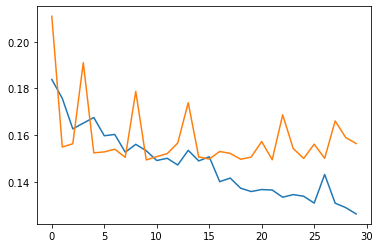

In [7]:
matPlt.plot(result.history['loss'][:], label='Training')
matPlt.plot(result.history['val_loss'][:], label='test')
modelCNN.summary()

In [8]:
testCoordsData = dataCoords[::1]
#testCoordsData = dataCoords

print('Process validation...')
getValid = lambda data : [ int(any([ any(c > 250 for c in row) for row in img[0] ])) for img in data ]
resultValid = utils.scanSatellite(pathValidation, testCoordsData, getValid, batch=1000)

Process validation...


In [9]:
print('Process score...')
getScore = lambda data : modelCNN.predict(encoder.predict(utils.formatData(data, res=64, toFloat=True), verbose=0), verbose=0)
result = utils.scanSatellite(pathSatellite, testCoordsData, getScore, batch=1000)

Process score...


In [10]:
print('Process confustion matrix...')
print(len(result))
resultTest = (np.asarray(result) > 0.7).astype(int)
confusionMatrix = confusion_matrix(resultValid, resultTest)
print(confusionMatrix)
print((confusionMatrix[1][1]) / (confusionMatrix[0][1] + confusionMatrix[1][1]) * 100,"%")

Process confustion matrix...
139113
[[110965   5484]
 [ 20430   2234]]
28.945322622441044 %


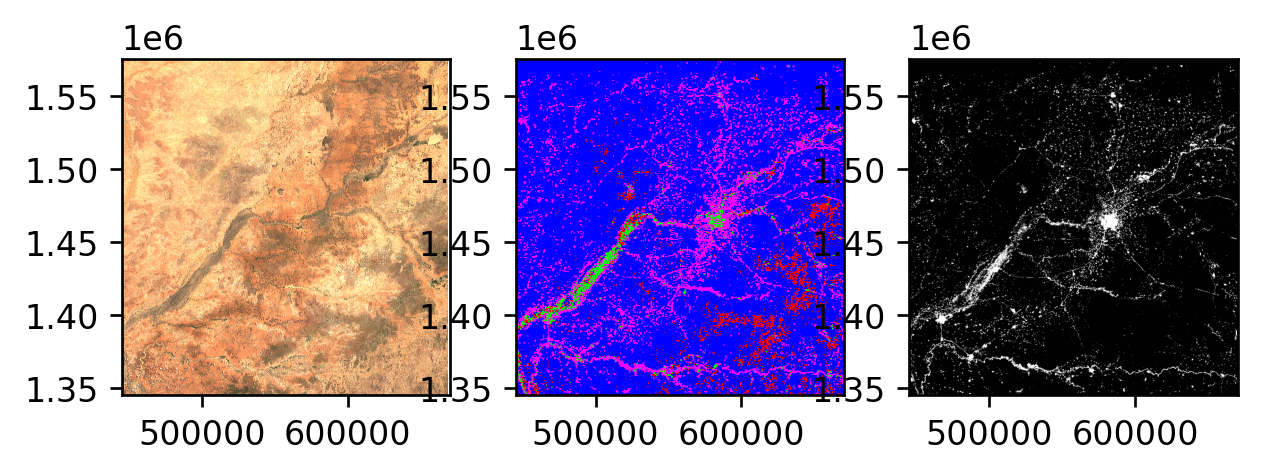

In [11]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, testCoordsData, resultTest, resultValid)

fig, axs = matPlt.subplots(1,3, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())

with rasterio.open(pathValidation) as p: rastPlt.show(p, ax=axs[2])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])

## save result

In [ ]:
img = np.copy(resultImg)
img[1,:,:767] = 150
img = img.transpose([1, 2, 0])
with rasterio.open(pathNight) as f:
  profile = f.profile
img = reshape_as_raster(img)
print(profile)
print(img.shape)

In [ ]:
with rasterio.open(folderName + 'example.tif', 'w', **profile) as f:
  f.write(img)


In [ ]:
print(resultImg[:,301,340])